In [284]:
import numpy as np
from hsa_hopper.kinematics import KinematicParameters, forward_kinematics
import hsa_hopper.dynamics
import yaml
from hsa_hopper.hsa_model import HSAPotential
from matplotlib import pyplot as plt

# load hsa potential
with open('hsa_model.yaml','r') as f:
    potential_attributes = yaml.load(f,yaml.Loader)
potential = HSAPotential.make_from_dict(potential_attributes)

L1 = .07
L2 = .15
kin_params = KinematicParameters(L1,L2,.3,-.003)
td_degrees = -20
lo_degrees = td_degrees - 1
theta1 = x_td = td_degrees*np.pi/180    # touchdown angle
thetaN = x_lo = lo_degrees*np.pi/180    # liftoff angle
tf = .2
dynamics_params = hsa_hopper.dynamics.DynamicsParameters(
    m=2.3,
    J=4e-3,
    bx=1.8e-1,
    by=0.,
    Kx=8.,
    # Kx=0,
    x0=x_lo,
    kinematics=kin_params,
    # hsa_potential=potential,
    hsa_potential=None,
    psi = -45
)

# kinematics functions
y = lambda x: forward_kinematics(kin_params,x)[0]
dy = lambda x: forward_kinematics(kin_params,x,jacobian=True)[1][0]
d2y = lambda x: forward_kinematics(kin_params,x,jacian=True,hessian=True)[2][0]


# stance boundary conditions
stance_boundary_cond = {
    'x1' : x_td,
    'xN' : x_lo,
    'y1' : float(y(x_td)),
    'yN' : float(y(x_lo)),
    'ydot1' : -0.7,
    'ydotN' : 1.
}

# for velocity boundary conditions in motor coordinates, need to solve for roots of velocity equation
from scipy.optimize import root_scalar
stance_boundary_cond['xdot1'] = root_scalar(
    lambda xdot: dy(theta1)*xdot-stance_boundary_cond['ydot1'], 
    bracket=(-20,20)).root
stance_boundary_cond['xdotN'] = root_scalar(
    lambda xdot: dy(theta1)*xdot-stance_boundary_cond['ydotN'], 
    bracket=(-20,20)).root

# startup boundary conditions
startup_boundary_cond = {
    'x1' : float(root_scalar(
            lambda theta: hsa_hopper.dynamics.evaluate(theta,0,0,dynamics_params),
            bracket=(-25*np.pi/180,0*np.pi/180)
        ).root),
    'xN' : x_lo,
    'xdot1' : 0.,
    'xdotN' : stance_boundary_cond['xdotN']
}

In [285]:
def make_interp_figure(x_interp, u_interp, dynamics_params):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(9,3))

    tk = x_interp.tk
    t_mat= np.vstack([np.linspace(tk[i], tk[i+1],100) for i in range(x_interp.M)])

    # compute interpolations
    x_data = np.hstack([[ x_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(x_interp.M)])
    y_data= y(x_data)
    u_data= np.hstack([[ u_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(u_interp.M)])
    t = t_mat.flatten()

    # make figures
    ax[0].plot(t, 180/np.pi*x_data)
    ax[1].plot(t, 100*y_data)
    ax[2].plot(t, u_data, label='feed-forward part')
    ax[2].plot(t, dynamics_params.Kx*(dynamics_params.x0-x_data), label='feed-back part')
    ax[2].plot(t, u_data+dynamics_params.Kx*(dynamics_params.x0-x_data), label='sum')

    ax[0].set_xlabel('Time (seconds)')
    ax[1].set_xlabel('Time (seconds)')
    ax[2].set_xlabel('Time (seconds)')

    ax[0].set_ylabel('theta (deg)')
    ax[1].set_ylabel('y (cm)')
    ax[2].set_ylabel('Torque (Nm)')
    ax[2].legend()
    fig.tight_layout()

def euler(x0, dt, steps, dynamics_params):
    t = np.zeros(steps+1)
    x = np.zeros((len(x0),steps+1))
    x[:,0] = x0
    for i in range(1,steps+1):
        f = hsa_hopper.dynamics.evaluate(x[0,i-1],x[1,i-1],0,dynamics_params)
        x[0,i] = x[0,i-1] + dt*x[1,i-1] + (.5*dt**2)*f
        x[1,i] = x[1,i-1] + dt*f
        t[i] = t[i-1] + dt
    return x,t

import hsa_hopper.collocation

def initial_guess(dynamics_params, collo_params, boundary_conditions, tf, dt):
    steps = int(tf/dt)
    x, t = euler(
        np.array([boundary_conditions['x1'], boundary_conditions['xdot1']]),
        dt,
        steps,
        dynamics_params
    )
    u = np.zeros(x.shape[1])
    x_interp, u_interp = hsa_hopper.collocation.fit_interpolation(x[0,:], u, t, collo_params)
    return x_interp, u_interp

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.9503093522003963
       x: [ 1.012e-01  8.373e-02 -3.693e-01 -9.246e-02 -8.970e-02
            1.366e+00 -1.498e+00 -6.658e+00 -1.527e+00]
     nit: 4
     jac: [ 1.303e+01  1.453e+00  3.881e-01 -2.197e+00 -2.285e+00
           -1.629e+00 -7.668e-01 -7.287e-01 -4.529e-01]
    nfev: 5
    njev: 4


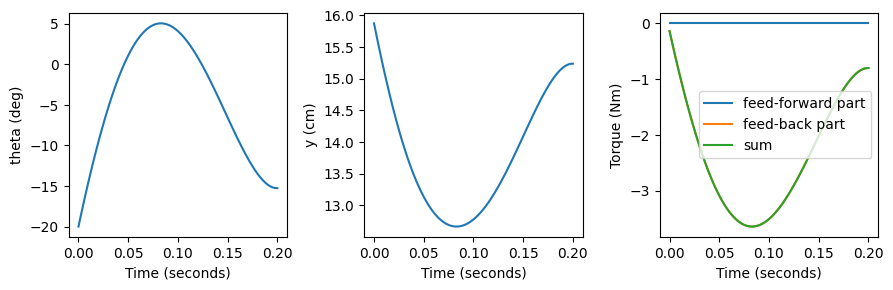

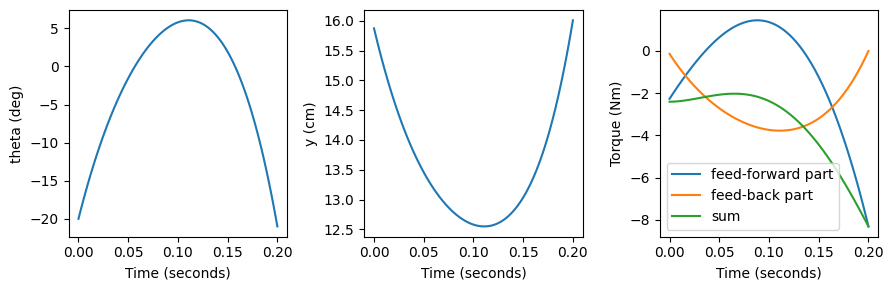

In [286]:
from scipy.optimize import minimize

# generate initial guess for the stance controller solution via
# forward simulation of passive system
collo_params = hsa_hopper.collocation.CollocationParameters(1,5,4,0,tf)
x_interp, u_interp = initial_guess(dynamics_params, 
                                   collo_params, 
                                   stance_boundary_cond,
                                   tf,
                                   1e-4)
make_interp_figure(x_interp, u_interp, dynamics_params)
z = np.hstack([x_interp.mat.flatten(),u_interp.mat.flatten()])

# solve optimal control problem for stance controller
bvp = hsa_hopper.collocation.HopBVP(
    [stance_boundary_cond['x1'],
     stance_boundary_cond['xdot1']],
    [stance_boundary_cond['xN'],
     stance_boundary_cond['xdotN']],
    [-50*np.pi/180,-20],
    [20*np.pi/180,20],
    dynamics_params,
    collo_params,
)
result = bvp.optimize(z, options = {
    'ftol': 1e-3,
    'maxiter': 200,
    'eps': 1e-4,
},
regeneration=False)
print(result)

x_interp_stance = hsa_hopper.collocation.PiecewiseInterpolation(bvp.c_mat,collo_params.tk)
u_interp_stance = hsa_hopper.collocation.PiecewiseInterpolation(bvp.d_mat,collo_params.tk)
make_interp_figure(x_interp_stance, u_interp_stance, dynamics_params)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7358693880290863
       x: [ 6.169e-02  1.645e-01 -3.227e-01 -2.700e-01  1.220e+00
           -2.077e+00 -4.464e+00 -2.811e+00]
     nit: 3
     jac: [ 1.151e+01  2.314e+00 -1.313e-01 -1.765e+00 -1.439e+00
           -8.361e-01 -6.523e-01 -4.997e-01]
    nfev: 3
    njev: 3


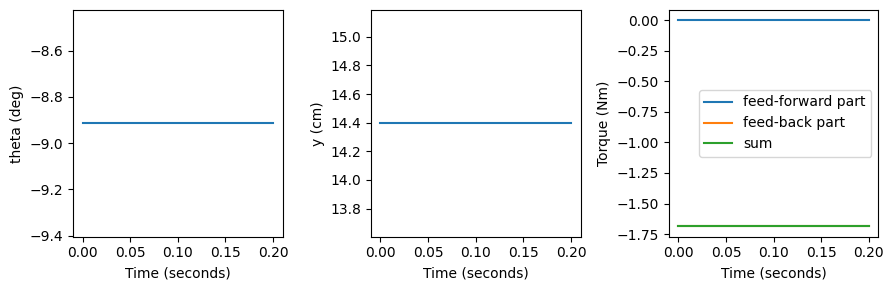

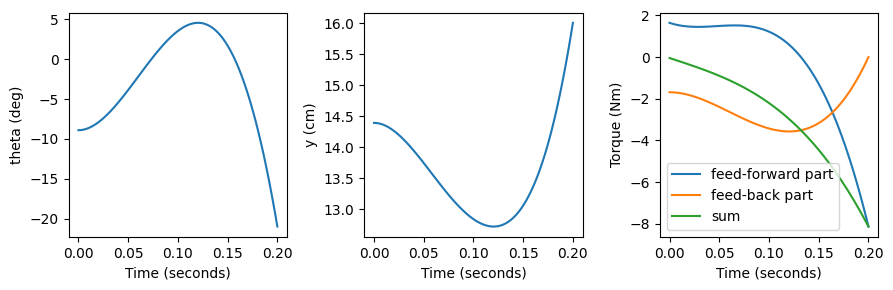

In [287]:
# generate initial guess for the startup controller solution via
# forward simulation of passive system
collo_params = hsa_hopper.collocation.CollocationParameters(1,4,4,0,tf)
x_interp, u_interp = initial_guess(dynamics_params, 
                                   collo_params, 
                                   startup_boundary_cond,
                                   tf,
                                   1e-4)
make_interp_figure(x_interp, u_interp, dynamics_params)
z = np.hstack([x_interp.mat.flatten(),u_interp.mat.flatten()])

# solve optimal control problem for startup controller
bvp = hsa_hopper.collocation.HopBVP(
    [startup_boundary_cond['x1'],
     startup_boundary_cond['xdot1']],
    [startup_boundary_cond['xN'],
     startup_boundary_cond['xdotN']],
    [-50*np.pi/180,-20],
    [20*np.pi/180,20],
    dynamics_params,
    collo_params,
)
result = bvp.optimize(z, options = {
    'ftol': 1e-3,
    'maxiter': 200,
    'eps': 1e-4,
},
regeneration=False)
print(result)

x_interp_startup= hsa_hopper.collocation.PiecewiseInterpolation(bvp.c_mat,collo_params.tk)
u_interp_startup= hsa_hopper.collocation.PiecewiseInterpolation(bvp.d_mat,collo_params.tk)
make_interp_figure(x_interp_startup, u_interp_startup, dynamics_params)

In [288]:
# build the controller
potential_string = 'hsa' if dynamics_params.hsa_potential is not None else 'no_hsa'
experiment_config = {
    'controller' : {
        'servo_pos' : int(1500 + dynamics_params.psi * 2000/1800*4),
        'kp' : [1.*dynamics_params.Kx, 3., 1.*dynamics_params.Kx],
        'kd' : [0., 0.125, 0.],
        'x0' : (x_lo*np.ones(3)).tolist(),
        'u_interp': [
            {
                'mat' : u_interp_startup.mat.tolist(),
                'tk' : u_interp_startup.tk.tolist(),
            },
            None,
            {
                'mat' : u_interp_stance.mat.tolist(),
                'tk' : u_interp_stance.tk.tolist()
            },
        ],
        'x_td' : x_td,
        'x_lo' : x_lo
    },
    'dynamics_params' : dynamics_params.attribute_dict(),
    'stance_boundary_cond' : stance_boundary_cond,
    'startup_boundary_cond' : startup_boundary_cond
}

fname = f'{potential_string}_{int(1000*dynamics_params.m)}g.yaml'
with open(fname, 'w') as f:
    yaml.dump(experiment_config, f, yaml.Dumper)